<a href="https://colab.research.google.com/github/zi-onion/24-2-ESAA/blob/main/11_18_CNN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

파이썬 딥러닝 텐서플로 ch4. 4 p.182-200

## 4. 위성 이미지 분류

### 4-1 텐서플로 데이터셋 로드
- 인공위성에서 지표면을 촬영한 이미지와 토지이용분류 값이 정리되어 있는 EuroSAT 데이터셋 제공.

In [1]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pylab as plt

# Tensorflow Datasets 활용
import tensorflow_datasets as tfds

In [2]:
# EuroSAT 위성 사진 데이터셋 로드

DATA_DIR = 'datasets/'

(train_ds, valid_ds), info = tfds.load('eurosat/rgb', split=['train[:80%]', 'train[80%:]'],
                                       shuffle_files=True,
                                       as_supervised=True,
                                       with_info=True,
                                       data_dir=DATA_DIR)
print(train_ds)
print(valid_ds)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling datasets/eurosat/rgb/incomplete.AJATA9_2.0.0/eurosat-train.tfrecord*...:   0%|          | 0/27000 [0…

Dataset eurosat downloaded and prepared to datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [3]:
# 메타 데이터 확인
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_dir=PosixGPath('/tmp/tmpa9pf2sjntfds'),
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(64, 64, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('ima

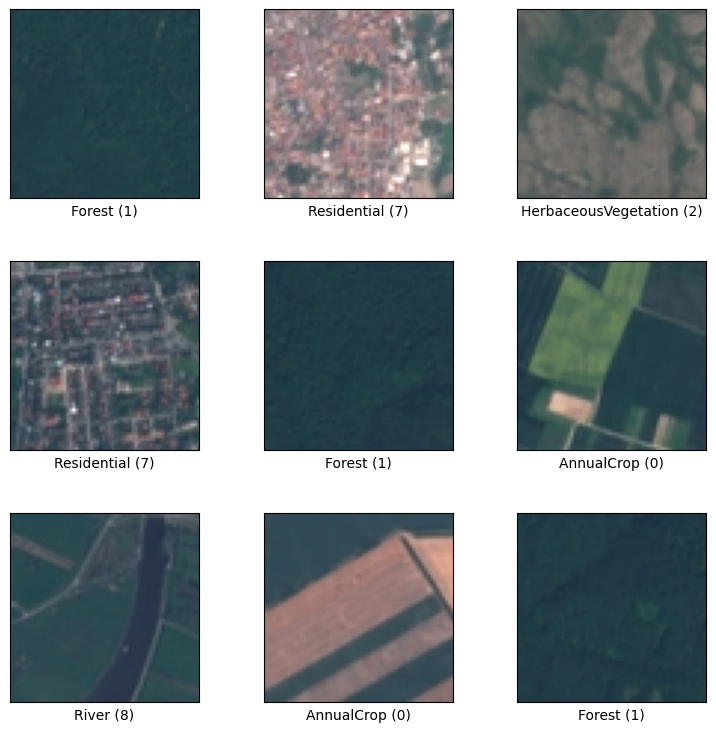

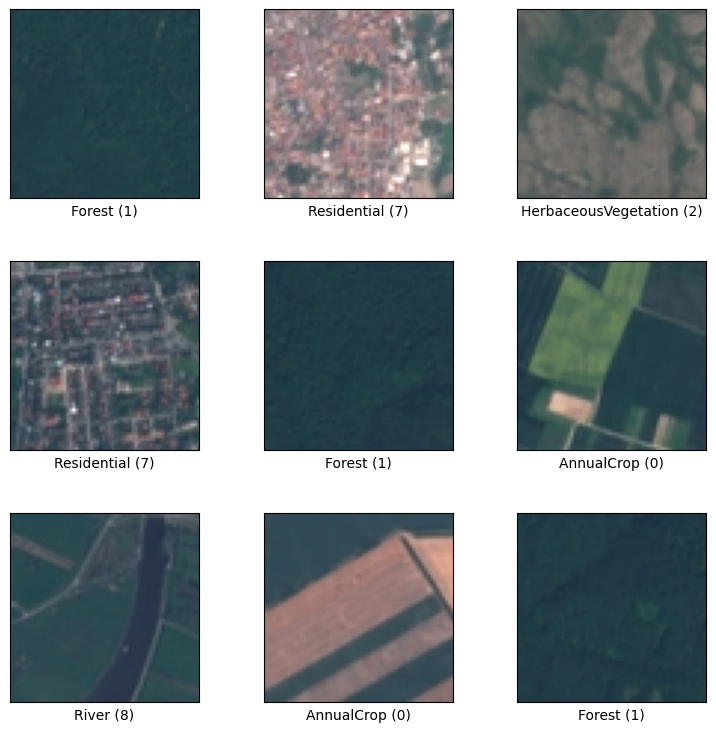

In [4]:
# 샘플 이미지를 메타 정보인 분류 레이블과 함께 화면에 출력
# 데이터 확인
tfds.show_examples(train_ds, info)

image  label
0  [[[56, 84, 121], [56, 85, 119], [67, 94, 124],...      5
1  [[[102, 105, 112], [105, 104, 110], [116, 107,...      7
2  [[[82, 98, 97], [83, 97, 97], [86, 97, 99], [9...      0
3  [[[56, 72, 87], [56, 72, 87], [52, 70, 82], [5...      1
4  [[[219, 154, 126], [218, 153, 125], [220, 154,...      0
5  [[[69, 83, 84], [67, 83, 83], [65, 80, 85], [6...      2
6  [[[28, 52, 76], [28, 52, 76], [31, 51, 75], [3...      9
7  [[[45, 75, 77], [46, 74, 78], [49, 69, 78], [6...      8
8  [[[135, 127, 124], [135, 127, 124], [132, 127,...      2
9  [[[40, 55, 74], [40, 55, 74], [41, 56, 75], [3...      9
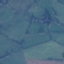
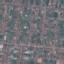
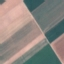
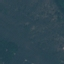
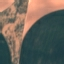
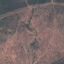
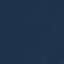
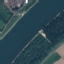
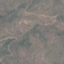
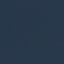

In [5]:
# as_dataframe 사용하여 샘플 출력
tfds.as_dataframe(valid_ds.take(10), info)

In [6]:
# 목표 클래스의 개수
NUM_CLASSES = info.features['label'].num_classes
print(NUM_CLASSES)

10


In [7]:
# 숫자 레이블을 활용해 문자열 메타 데이터로 변환
print(info.features['label'].int2str(6))

PermanentCrop


### 4-2 데이터 전처리


- 텐서플로 연산은 float32 숫자 값을 사용하기 때문에, cast 함수를 사용하여 자료형을 float32로 변환.
- 입력 이미지는 0~255 범위의 픽셀 값을 갖기 때문에 255로 나눠서 정규화. <- 이 과정을 처리하는 preprocess_data 함수 정의
- map 함수는 사용자 정의 함수를 매핑하여 텐서플로 데이터셋에 적용하는 메소드로 전처리 과정에서 매우 유용.
  - num_parallel_calls 옵션을 AUTOTUNE으로 지정하면 텐서플로 병렬연산 처리를 자동으로 최적화.
  

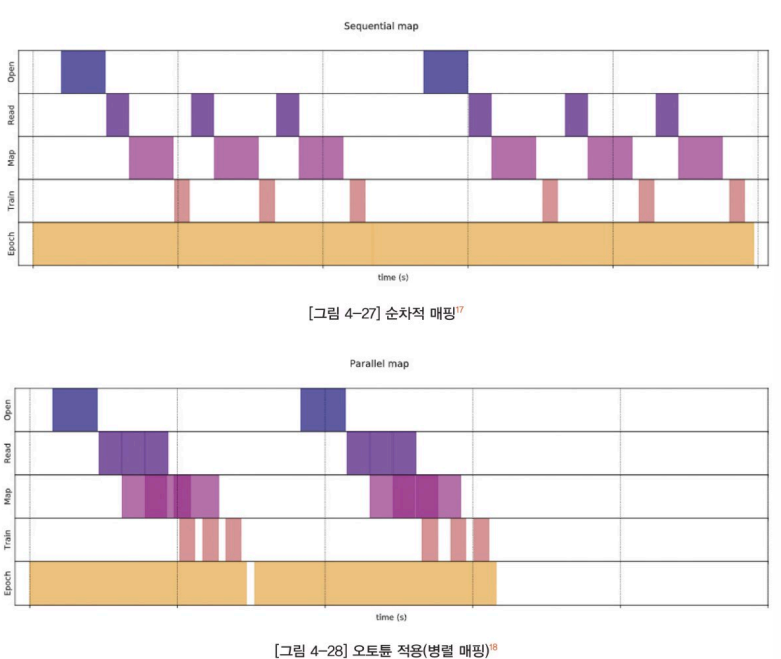

- 정규화변환을 마친 데이터셋에 shuffle() 메소드 적용 시, 순서 랜덤하게 섞어줌. BUFFER_SIZE를 1000으로 지정, BATCH_SIZE를 64로 지정.
- prefetch() 메소드는 모델이 훈련을 진행하는 동안 다음에 입력할 데이터를 불러와서 미리 전처리를 하도록 시스템을 조율. -> 병렬 처리를 통해 모델 훈련 시간 단축.

In [8]:
# 데이터 전처리 파이프라인
BATCH_SIZE=64
BUFFER_SIZE=1000

def preprocess_data(image, label):
  image = tf.cast(image, tf.float32)/255. # 0~1 정규화. float32 변환
  return image, label

train_data = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

- shuffle 함수의 주요 파라미터인 buffer_size, 데이터셋의 크기가 작은 경우 전체 데이터셋의 개수만큼 지정해주는 것이 무작위성 확보 유리

### 4-3 모델 훈련 및 검증

In [9]:
'''
배치 정규화, 합성곱, 풀링 레이어로 구성된 유닛 2개 연결 ~>
Dense 레이어와 Dropout으로 구성된 최종 분류기를 갖는 딥러닝 모델을 Sequential API로 생성
'''
def build_model():

  model = tf.keras.Sequential([
      # Convolution 층
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D((2, 2)),

      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D((2,2)),

      #Classifier 출력층
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0, 3),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0, 3),
      tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')

  ])
  return model

model = build_model()

In [10]:
'''
예측 클래스가 10개인 다중 분류 문제에 맞게 손실함수와 평가지표를 설정~>
모델을 50 epoch 훈련
'''
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_data, validation_data=valid_data, epochs=5)

Epoch 1/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 277s 795ms/step - accuracy: 0.5665 - loss: 1.3915 - val_accuracy: 0.5281 - val_loss: 1.2859
Epoch 2/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 251s 590ms/step - accuracy: 0.7485 - loss: 0.7150 - val_accuracy: 0.8265 - val_loss: 0.4962
Epoch 3/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 194s 566ms/step - accuracy: 0.8176 - loss: 0.5246 - val_accuracy: 0.8078 - val_loss: 0.5669
Epoch 4/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 195s 576ms/step - accuracy: 0.8517 - loss: 0.4183 - val_accuracy: 0.8441 - val_loss: 0.4517
Epoch 5/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 200s 570ms/step - accuracy: 0.8854 - loss: 0.3300 - val_accuracy: 0.8252 - val_loss: 0.5420


In [11]:
def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss,'b', label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss,'r', label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc,'b', label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc,'r', label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

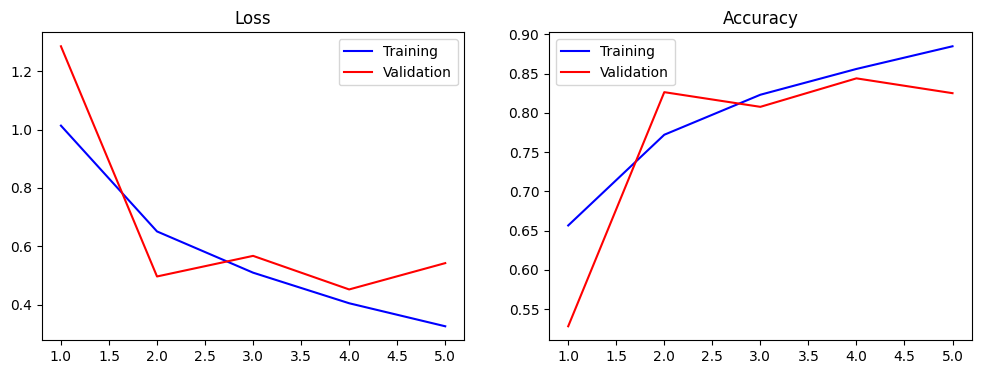

In [12]:
# 손실함수, 정확도 그래프 그리기
plot_loss_acc(history, 5)
## epoch=50까지 그리면 epoch 10이후로는 검증 셋에 대한 손실함수가 더 이상 줄어들지 않으면서 과대적합 경향을 나타냄

### 4-4 데이터 증강 Data Augmentation


과대적합을 해소하는 기법인 배치 정규화, Dropout 등을 적용했음에도 과대적합이 발생
- 데이터 증강 Data Augmentation: 이미지 분류 문제에서 과대적합 해소, 모델의 일반화된 Robust한 성능을 확보하는 기법. 이미지 데이터에 여러가지 변형을 주어서 훈련 데이터의 다양성 확보. 모델이 새로운 데이터에 대한 예측력 강화하도록 하는 개념.

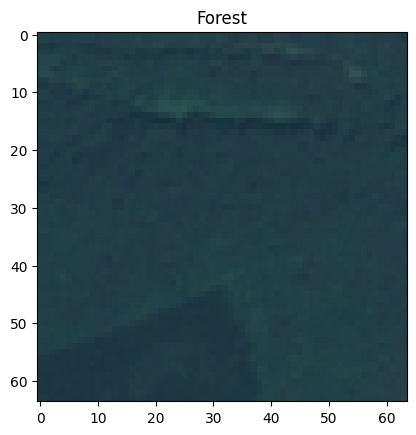

In [13]:
# 샘플 이미지
image_batch, label_batch = next(iter(train_data.take(10)))

image = image_batch[0]
label = label_batch[0].numpy()

plt.imshow(image)
plt.title(info.features['label'].int2str(label));

In [14]:
# 데이터 증강 전후를 비교하는 시각화 함수를 정의
def plot_augmentation(original, augmented):

  fig, axes = plt.subplots(1, 2, figsize=(12, 4))

  axes[0].imshow(original)
  axes[0].set_title('Original')

  axes[1].imshow(augmented)
  axes[1].set_title('Augmented')

  plt.show()

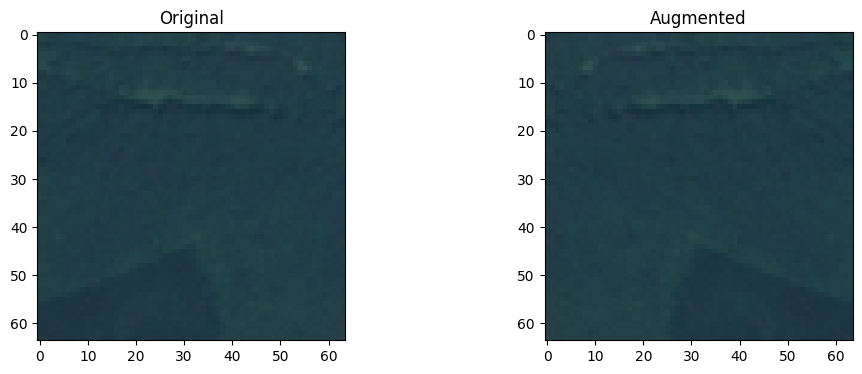

In [15]:
# tf.image 모듈의 flip_left_right 함수를 사용하여 이미지를 좌우 방향으로 뒤집기
lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image, lr_flip)

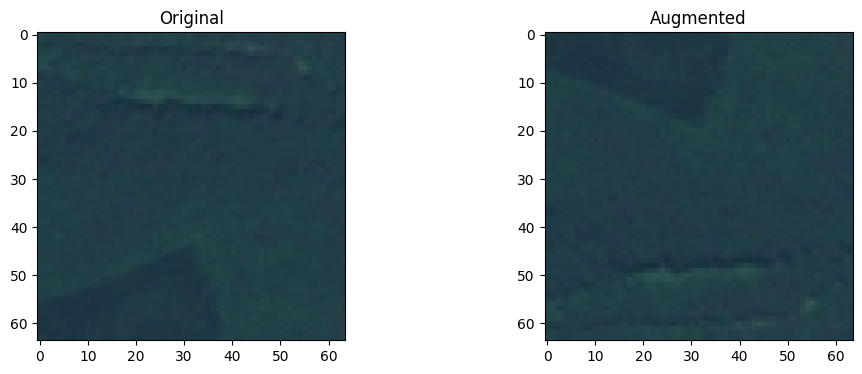

In [16]:
# flip_up_down 함수를 사용하여 이미지를 상하 방향으로 뒤집기
ud_flip = tf.image.flip_up_down(image)
plot_augmentation(image, ud_flip)

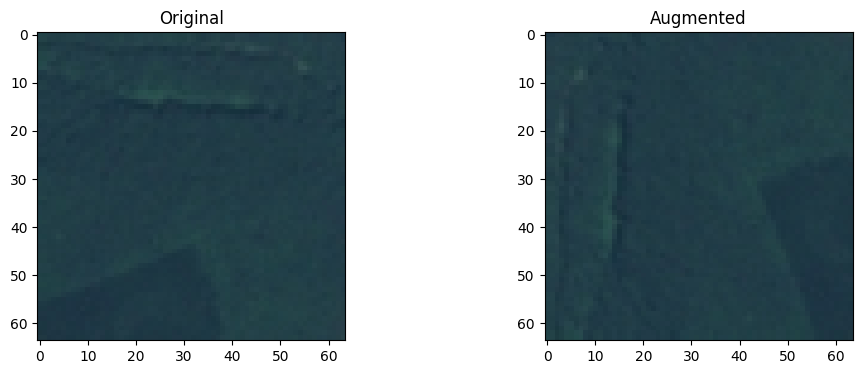

In [17]:
# rot90 함수를 사용하면 이미지를 반시계 방향으로 90도 회전시킴
rotate90 = tf.image.rot90(image)
plot_augmentation(image, rotate90)

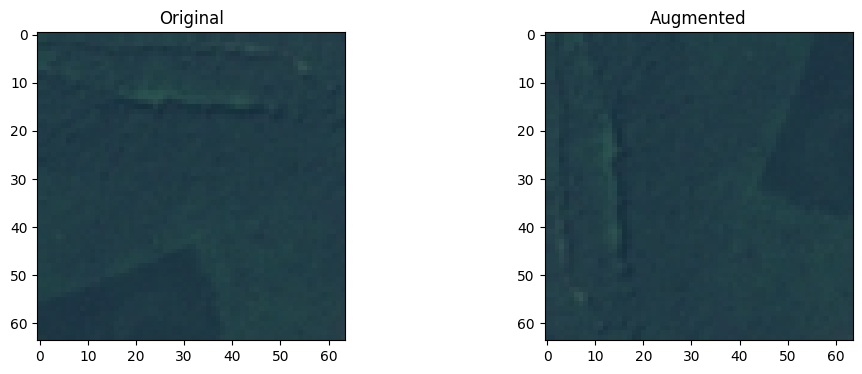

In [18]:
# transpose 함수는 이미지 텐서 행렬의 행과 열을 바꿔줌
transpose = tf.image.transpose(image)
plot_augmentation(image, transpose)

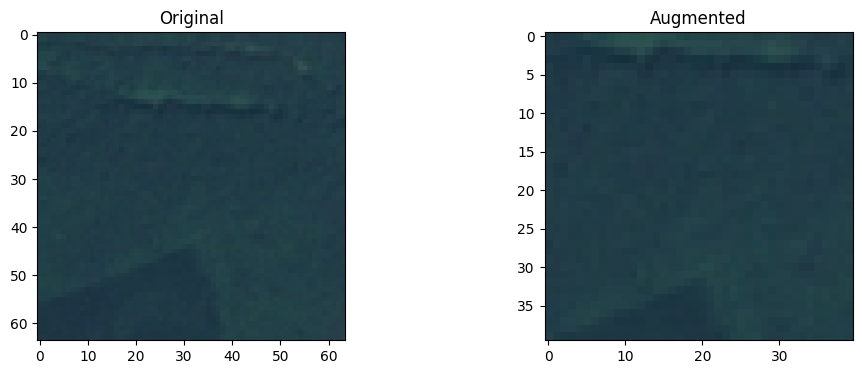

In [19]:
# 이미지 자르기 1
crop1 = tf.image.central_crop(image, central_fraction=0.6)
plot_augmentation(image, crop1)

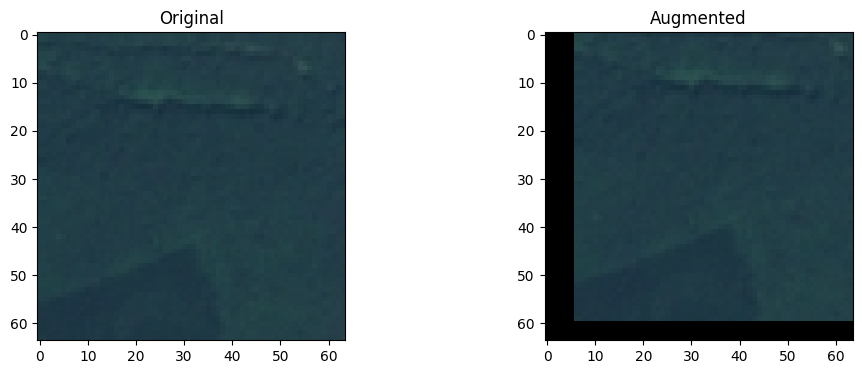

In [20]:
# 이미지 자르기 2
img = tf.image.resize_with_crop_or_pad(image, 64+20, 64+20) # 사이즈 키우기
crop2 = tf.image.random_crop(img, size = [64, 64, 3])
plot_augmentation(image, crop2)

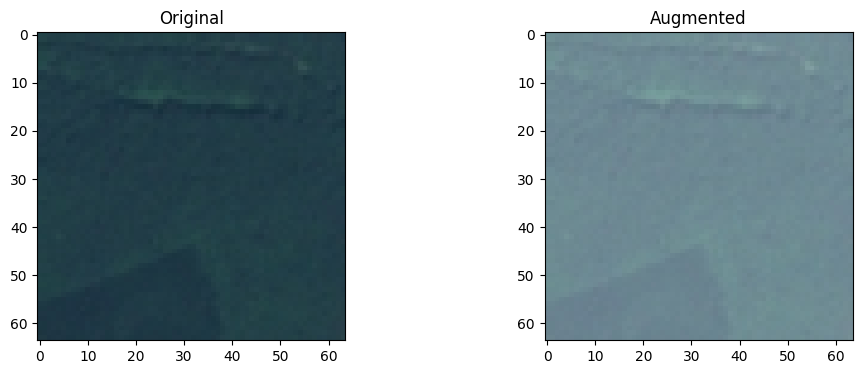

In [21]:
#이미지 밝기 조정
brightness = tf.image.adjust_brightness(image, delta=0.3)
plot_augmentation(image, brightness)

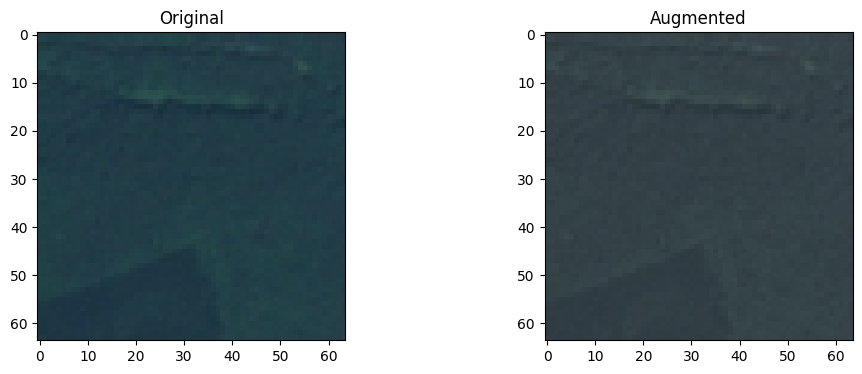

In [22]:
# 이미지 채도
saturation = tf.image.adjust_saturation(image, saturation_factor=0.5)
plot_augmentation(image, saturation)

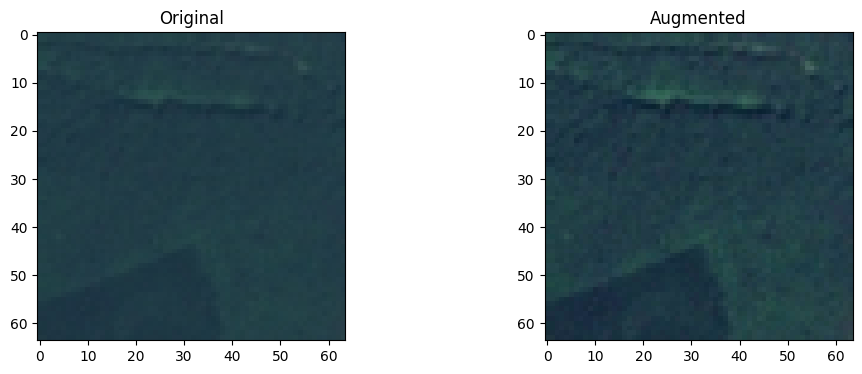

In [23]:
# 이미지 대비
contrast = tf.image.adjust_contrast(image, contrast_factor=2)
plot_augmentation(image, contrast)

In [24]:
# 이미지 증강 전처리
def data_augmentation(image, label):

  image = tf.image.random_flip_left_right(image) # 좌우 반전
  image = tf.image.random_flip_up_down(image) # 상하 반전
  image = tf.image.random_brightness(image, max_delta=0.3) # 밝기 변화
  image = tf.image.random_crop(image, size=[64, 64, 3])

  image = tf.cast(image, tf.float32)/255. #0~1 정규화

  return image, label

train_aug = train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

print(train_aug)
print(valid_aug)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [25]:
# 모델 생성
aug_model = build_model()

# 모델 컴파일
aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
aug_history = aug_model.fit(train_aug,
                            validation_data=valid_aug,
                            epochs=5)

Epoch 1/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 201s 583ms/step - accuracy: 0.3768 - loss: 1.8706 - val_accuracy: 0.4506 - val_loss: 1.4457
Epoch 2/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 205s 607ms/step - accuracy: 0.6052 - loss: 1.0869 - val_accuracy: 0.6500 - val_loss: 0.9487
Epoch 3/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 249s 570ms/step - accuracy: 0.6806 - loss: 0.8745 - val_accuracy: 0.6976 - val_loss: 0.8374
Epoch 4/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 193s 569ms/step - accuracy: 0.7259 - loss: 0.7575 - val_accuracy: 0.7302 - val_loss: 0.7417
Epoch 5/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 200s 591ms/step - accuracy: 0.7614 - loss: 0.6565 - val_accuracy: 0.7767 - val_loss: 0.6303


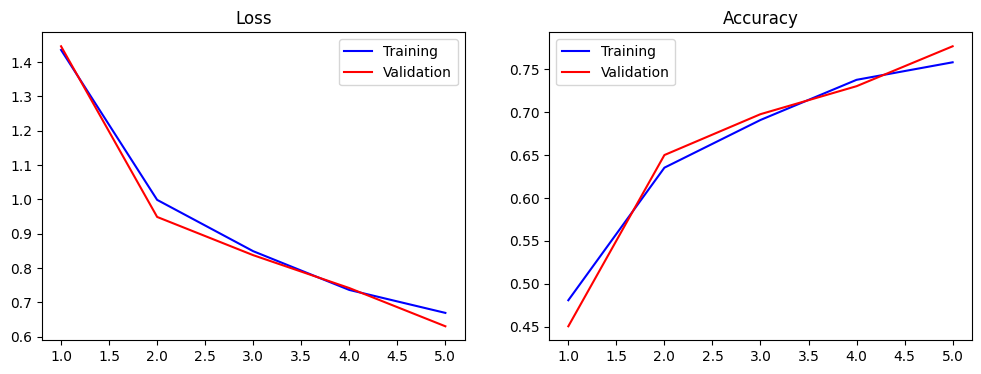

In [26]:
# 손실함수, 정확도 그래프 그리기
plot_loss_acc(aug_history, 5)

### 4-5 ResNet 사전 학습 모델
- ResNet 모델(이미지넷 경진 대회에서 우승한 모델)을 활용해서 위성 이미지 분류.
- 전이 학습transfer learning: 딥러닝 모델의 구조와 가중치를 그대로 가져오고, 모델의 끝단에 위치하는 Top 층에 위성 이미지를 분류할 수 있는 최종 분류기를 추가하는 방식으로 모델을 구성.
- keras에서 모델 인스턴스를 직접 불러오기 가능.
  - keras에서 이미지 크기를 우리가 지정한 크기로 맞춰서 줄여줌.

In [27]:
!pip install keras

In [28]:
# pre-trained model을 사전 학습된 가중치와 함께 가져오기
from tensorflow.keras.applications import ResNet50V2

pre_trained_base = ResNet50V2(include_top=False,
                              weights='imagenet',
                              input_shape=[64, 64, 3])

# 사전 학습된 가중치를 업데이트 되지 않도록 설정
pre_trained_base.trainable = False

# 모델 구조 시각화
from tensorflow.keras.utils import plot_model
plot_model(pre_trained_base, show_shapes=True, show_layer_names=True, to_file='/content/resnet50.png')

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.537852 to fit



In [29]:
# Top 층에 Classifier 추가

def build_transfer_classifier():
    model = tf.keras.Sequential([
        # Pre-trained Base
        pre_trained_base,
        # Classifier Layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
    ])

    return model

# 모델 구조
tc_model = build_transfer_classifier()
tc_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 2, 2, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,622,410 (93.93 MB)

 Trainable params: 1,057,610 (4.03 MB)

 Non-trainable params: 23,564,800 (89.89 MB)